In [7]:
from glob import glob

In [8]:
glob('Results/ROI_3_Layer_12/ROI_3_Layer_12_0_Vgg/*')

['Results/ROI_3_Layer_12/ROI_3_Layer_12_0_Vgg/Vgg_model_3_12_epoch_9_loss_0.10758378246867381_sparsity_0.001_smoothness_0.001_groupsparsity_0.01.pt',
 'Results/ROI_3_Layer_12/ROI_3_Layer_12_0_Vgg/training_data_3_12.npy',
 'Results/ROI_3_Layer_12/ROI_3_Layer_12_0_Vgg/training_summary_3_layer_12.png']

In [9]:
os.path.abspath('Results/ROI_3_Layer_12/ROI_3_Layer_12_0_Vgg/Vgg_model_3_12_epoch_9_loss_0.10758378246867381_sparsity_0.001_smoothness_0.001_groupsparsity_0.01.pt')

'/home/jose/Desktop/lucent-things/Results/ROI_3_Layer_12/ROI_3_Layer_12_0_Vgg/Vgg_model_3_12_epoch_9_loss_0.10758378246867381_sparsity_0.001_smoothness_0.001_groupsparsity_0.01.pt'

In [10]:
def correlations(model:str):

    import torch
    from lucent.modelzoo import vgg19, util
    from cadena_model_vgg import VggModel
    from cadena_model_inception import InceptionModel

    vgg_pretrained = vgg19(pretrained = True)

    gpu_to_use = 0

    neurons_per_roi = {1: 43,   # Key: Roi number    Values: number of active neurons
    2: 62,
    3: 55,
    4: 50,
    5: 51,
    7: 53,
    8: 60,
    9: 43,
    10: 44,
    11: 53,
    12: 29,
    13: 17,
    14: 24,
    15: 59,
    16: 24,
    }


    file_of_model_to_load = model
    roi, layer = file_of_model_to_load.split('/')[-1].split('_')[2:4]
    roi = int(roi)
    roi_name = str(roi)
    if layer.isdigit():
        layer = int(layer)
    n_neurons=neurons_per_roi[roi]


    GPU = torch.cuda.is_available()
    net = VggModel(pretrained_model=vgg_pretrained, conv_layer=layer, num_neurons=n_neurons, device = torch.device("cuda:"+str(gpu_to_use) if GPU else "cpu"))
    net.cuda()

    print('\n1/5  Model loading...')
    net.load_state_dict(torch.load(file_of_model_to_load, map_location=torch.device("cuda:"+str(gpu_to_use) if GPU else "cpu")))
    print(net(torch.rand([14, 3, 224, 224]).cuda()).shape)

    # Untrained network, apparently need to have the line defining the pretrained network right before it or it doesnt work
    vgg_pretrained = vgg19(pretrained = True)
    net_untrained = VggModel(pretrained_model=vgg_pretrained, conv_layer=layer, num_neurons=n_neurons, device = torch.device("cuda:"+str(gpu_to_use) if GPU else "cpu"))
    net_untrained.cuda()

    print('      Model loaded and tested...\n')



    ###############   2. Loading paolo model

    print('\n2/5   Loading Paolo\'s model')
    from neural_model import Model
    from lucent.modelzoo import inceptionv1, util, inceptionv1_avgPool
    import pickle
    import numpy as np

    def load_trained_model(roi_name,layer=False):
        if not layer:
            data_filename = '/home/jose/Desktop/snapshots/grid_search_array'+ roi_name +'.pkl'
            f = open(data_filename,"rb")
            cc = pickle.load(f)
            val_corrs = cc['val_corrs']
            params = cc['params']
            val_corrs = np.array(val_corrs)
            layer = params[np.where(val_corrs==val_corrs.max())[0][0].astype('int')][0]
        data_filename      = '/home/jose/Desktop/Data/data_THINGS_array'+ roi_name +'_v1.pkl'
        #data_filename = '/media/stijn/2bb74e85-3681-4561-88b7-abd98482de61/paolo/Data/data_THINGS_array'+ roi_name +'_v1.pkl'
        f = open(data_filename,"rb")
        cc = pickle.load(f)
        val_data = cc['val_data']
        del cc
        
        n_neurons = val_data.shape[1]

        pretrained_model = inceptionv1(pretrained=True)
        roi_model = Model(pretrained_model,layer,n_neurons,device='cpu')
        snapshot_path = f'/home/jose/Desktop/snapshots/array'+ roi_name +'_neural_model.pt'
        roi_model.load_state_dict(torch.load(snapshot_path,map_location=torch.device('cpu')))
        return roi_model,n_neurons


    model_paolo, n_neurons = load_trained_model(roi_name)
    print('      Loaded\n')



    ############ Loading the activations in the val and training data

    print('\n3/5   Loading activations...')
    import pickle
    import numpy as np
    import itertools
    import scipy
    import matplotlib.pyplot as plt

    data_filename  = '/home/jose/Desktop/Data/data_THINGS_array'+ roi_name +'_v1.pkl'

    f = open(data_filename,"rb")
    cc = pickle.load(f)

    train_data = cc['train_data']
    val_data = cc['val_data']
    img_data = cc['img_data']
    val_img_data = cc['val_img_data']
    n_neurons = train_data.shape[1]
    print('      Loaded\n')




    ########### Getting validation activations

    print('\n4/5   Getting validation activations...')
    val_data_net   = net(val_img_data.cuda())
    val_data_net   = val_data_net.cpu().detach().numpy()


    val_data_paolo = model_paolo(val_img_data)
    val_data_paolo = val_data_paolo.cpu().detach().numpy()
    val_data_paolo = val_data_paolo[:,:,0,0]


    val_untrained = net_untrained(val_img_data.cuda())
    val_untrained = val_untrained.cpu().detach().numpy()
    print('      Done\n')


    print('\n5/5   Plotting...')
    f, ax = plt.subplots(10,10, figsize = (30,10))
    idx = 2

    f.suptitle('ROI: ' + str(roi_name) + '  Regularization L1\n Black: ground truth ; Red: Me ; Blue: Paolo\'s ')
    for i in range(100):
        ax[i//10, i%10].plot(val_data[i, :], 'k', label = 'Data')
        ax[i//10, i%10].plot(val_data_net[i, :], 'r--', label = 'Network')
        ax[i//10, i%10].plot(val_data_paolo[i, :], 'b:', label = 'Paolo')
        ax[i//10, i%10].set_title('Image ' + str(i+1))

    #plt.savefig('Roi_3_layer_10_val_activations.png', dpi = 150)
    print('      Done\n')
    plt.show()


    ##################################################################################################
    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    correlations = []

    for i in range(val_data.shape[1]):
        correlations.append(np.corrcoef(val_data[:, i], val_data_net[:, i])[1,0])
    correlations = np.array(correlations)

    return correlations

/home/jose/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jose/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv_layer:   12 <class 'int'>
FTE:          [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]
conv in FTE True



features.12
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
[256, 56, 56, 55]

1/5  Model loading...
torch.Size([14, 55])
conv_layer:   12 <class 'int'>
FTE:          [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]
conv in FTE True



features.12
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
[256, 56, 56, 55]
      Model loaded and tested...


2/5   Loading Paolo's model
conv2d2
RedirectedReluLayer()
      Loaded


3/5   Loading activations...
      Loaded


4/5   Getting validation activations...
      Done


5/5   Plotting...
      Done



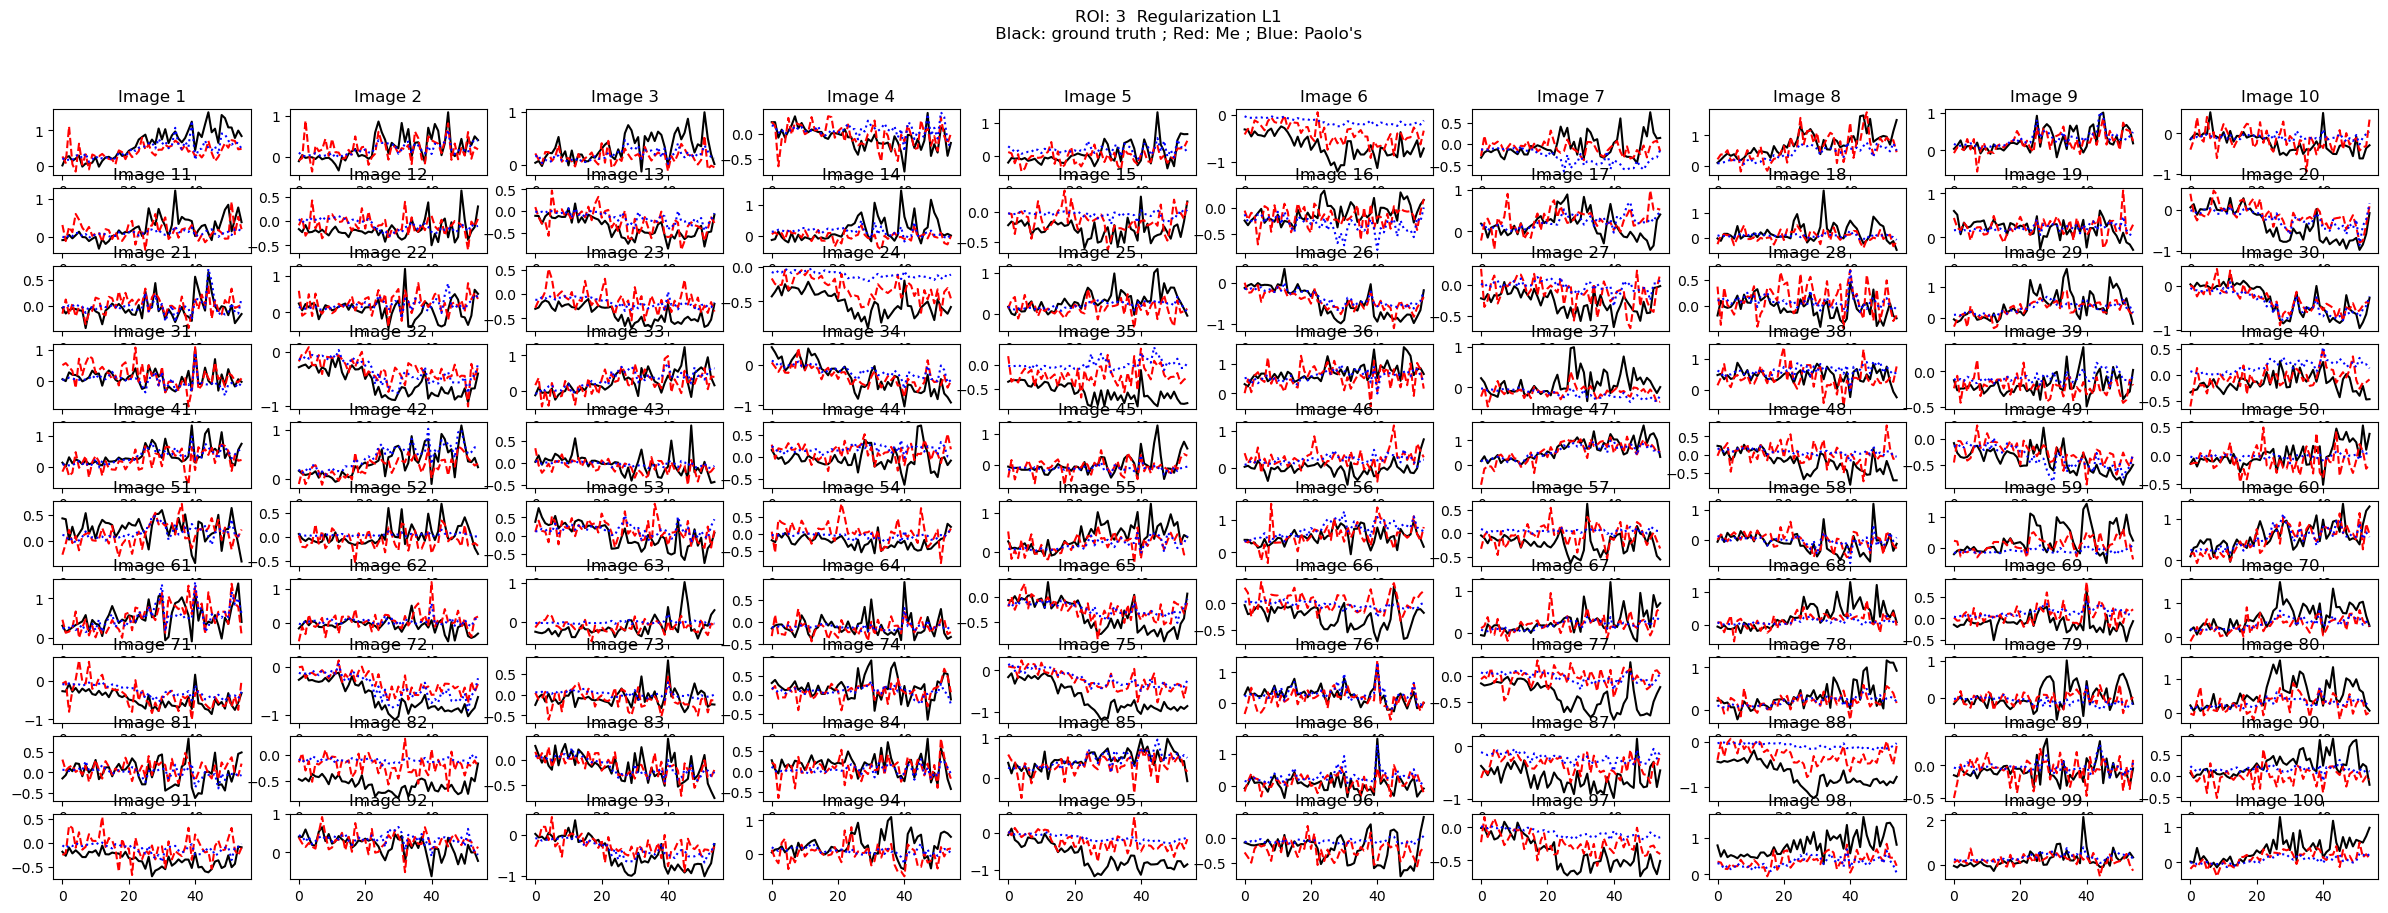

array([0.42598722, 0.50816406, 0.44339867, 0.50609669, 0.32731301,
       0.38564646, 0.56042586, 0.49436923, 0.43461259, 0.65592953,
       0.50670979, 0.68423681, 0.34876737, 0.73405793, 0.69484046,
       0.66184767, 0.63726773, 0.67127929, 0.64014625, 0.56340224,
       0.78247248, 0.51922689, 0.62043112, 0.80289814, 0.79009289,
       0.82815141, 0.801272  , 0.79418779, 0.82205689, 0.79484095,
       0.79175981, 0.75875475, 0.62118168, 0.74812592, 0.82350865,
       0.78325944, 0.67261989, 0.71584294, 0.46070026, 0.7440527 ,
       0.7424389 , 0.78872201, 0.77909642, 0.82514398, 0.67160471,
       0.61861413, 0.7938214 , 0.68594406, 0.78259419, 0.76370857,
       0.75862135, 0.70028242, 0.71325911, 0.85294584, 0.5988671 ])

In [ ]:
correlations('/home/jose/Desktop/lucent-things/Results/ROI_3_Layer_12/ROI_3_Layer_12_0_Vgg/Vgg_model_3_12_epoch_9_loss_0.10758378246867381_sparsity_0.001_smoothness_0.001_groupsparsity_0.01.pt')

In [ ]:
import torch
from lucent.modelzoo import vgg19, util
from cadena_model_vgg import VggModel
from cadena_model_inception import InceptionModel

vgg_pretrained = vgg19(pretrained = True)

gpu_to_use = 0

neurons_per_roi = {1: 43,   # Key: Roi number    Values: number of active neurons
 2: 62,
 3: 55,
 4: 50,
 5: 51,
 7: 53,
 8: 60,
 9: 43,
 10: 44,
 11: 53,
 12: 29,
 13: 17,
 14: 24,
 15: 59,
 16: 24,
 }


file_of_model_to_load = '/home/jose/Desktop/lucent-things/Results/ROI_3_Layer_12/ROI_3_Layer_12_0_Vgg/Vgg_model_3_12_epoch_9_loss_0.10758378246867381_sparsity_0.001_smoothness_0.001_groupsparsity_0.01.pt'
roi, layer = file_of_model_to_load.split('/')[-1].split('_')[2:4]
roi = int(roi)
roi_name = str(roi)
if layer.isdigit():
    layer = int(layer)
n_neurons=neurons_per_roi[roi]


GPU = torch.cuda.is_available()
net = VggModel(pretrained_model=vgg_pretrained, conv_layer=layer, num_neurons=n_neurons, device = torch.device("cuda:"+str(gpu_to_use) if GPU else "cpu"))
net.cuda()

print('\n1/5  Model loading...')
net.load_state_dict(torch.load(file_of_model_to_load, map_location=torch.device("cuda:"+str(gpu_to_use) if GPU else "cpu")))
print(net(torch.rand([14, 3, 224, 224]).cuda()).shape)

# Untrained network, apparently need to have the line defining the pretrained network right before it or it doesnt work
vgg_pretrained = vgg19(pretrained = True)
net_untrained = VggModel(pretrained_model=vgg_pretrained, conv_layer=layer, num_neurons=n_neurons, device = torch.device("cuda:"+str(gpu_to_use) if GPU else "cpu"))
net_untrained.cuda()

print('      Model loaded and tested...\n')



###############   2. Loading paolo model

print('\n2/5   Loading Paolo\'s model')
from neural_model import Model
from lucent.modelzoo import inceptionv1, util, inceptionv1_avgPool
import pickle
import numpy as np

def load_trained_model(roi_name,layer=False):
    if not layer:
        data_filename = '/home/jose/Desktop/snapshots/grid_search_array'+ roi_name +'.pkl'
        f = open(data_filename,"rb")
        cc = pickle.load(f)
        val_corrs = cc['val_corrs']
        params = cc['params']
        val_corrs = np.array(val_corrs)
        layer = params[np.where(val_corrs==val_corrs.max())[0][0].astype('int')][0]
    data_filename      = '/home/jose/Desktop/Data/data_THINGS_array'+ roi_name +'_v1.pkl'
    #data_filename = '/media/stijn/2bb74e85-3681-4561-88b7-abd98482de61/paolo/Data/data_THINGS_array'+ roi_name +'_v1.pkl'
    f = open(data_filename,"rb")
    cc = pickle.load(f)
    val_data = cc['val_data']
    del cc
    
    n_neurons = val_data.shape[1]

    pretrained_model = inceptionv1(pretrained=True)
    roi_model = Model(pretrained_model,layer,n_neurons,device='cpu')
    snapshot_path = f'/home/jose/Desktop/snapshots/array'+ roi_name +'_neural_model.pt'
    roi_model.load_state_dict(torch.load(snapshot_path,map_location=torch.device('cpu')))
    return roi_model,n_neurons


model_paolo, n_neurons = load_trained_model(roi_name)
print('      Loaded\n')



############ Loading the activations in the val and training data

print('\n3/5   Loading activations...')
import pickle
import numpy as np
import itertools
import scipy
import matplotlib.pyplot as plt

data_filename  = '/home/jose/Desktop/Data/data_THINGS_array'+ roi_name +'_v1.pkl'

f = open(data_filename,"rb")
cc = pickle.load(f)

train_data = cc['train_data']
val_data = cc['val_data']
img_data = cc['img_data']
val_img_data = cc['val_img_data']
n_neurons = train_data.shape[1]
print('      Loaded\n')




########### Getting validation activations

print('\n4/5   Getting validation activations...')
val_data_net   = net(val_img_data.cuda())
val_data_net   = val_data_net.cpu().detach().numpy()


val_data_paolo = model_paolo(val_img_data)
val_data_paolo = val_data_paolo.cpu().detach().numpy()
val_data_paolo = val_data_paolo[:,:,0,0]


val_untrained = net_untrained(val_img_data.cuda())
val_untrained = val_untrained.cpu().detach().numpy()
print('      Done\n')


print('\n5/5   Plotting...')
f, ax = plt.subplots(10,10, figsize = (30,10))
idx = 2

f.suptitle('ROI: ' + str(roi_name) + '  Regularization L1\n Black: ground truth ; Red: Me ; Blue: Paolo\'s ')
for i in range(100):
    ax[i//10, i%10].plot(val_data[i, :], 'k', label = 'Data')
    ax[i//10, i%10].plot(val_data_net[i, :], 'r--', label = 'Network')
    ax[i//10, i%10].plot(val_data_paolo[i, :], 'b:', label = 'Paolo')
    ax[i//10, i%10].set_title('Image ' + str(i+1))

#plt.savefig('Roi_3_layer_10_val_activations.png', dpi = 150)
print('      Done\n')
plt.show()

KeyboardInterrupt: 